We will use the test/train/val datasets to train one model, and next we will split sentimentdataset into test/train/val to train a different model, then compare model performances.

In [10]:
import pandas as pd

file_path = "C:/Users/gresn/OneDrive/CSDS312/ProjectFiles/train.csv" 
df = pd.read_csv(file_path)

df.dropna(inplace=True)

df["Addicted"] = (df["Daily_Usage_Time (minutes)"] > 120).astype(int)

count_more_than_120 = df["Addicted"].sum()
count_less_than_120 = (df["Addicted"] == 0).sum()

print(df[["Daily_Usage_Time (minutes)", "Addicted"]].head())
print(f"Number of people with Daily Usage Time greater than 120 minutes: {count_more_than_120}")
print(f"Number of people with Daily Usage Time less than or equal to 120 minutes: {count_less_than_120}")


   Daily_Usage_Time (minutes)  Addicted
0                       120.0         0
1                        90.0         0
2                        60.0         0
3                       200.0         1
4                        45.0         0
Number of people with Daily Usage Time greater than 120 minutes: 220
Number of people with Daily Usage Time less than or equal to 120 minutes: 780


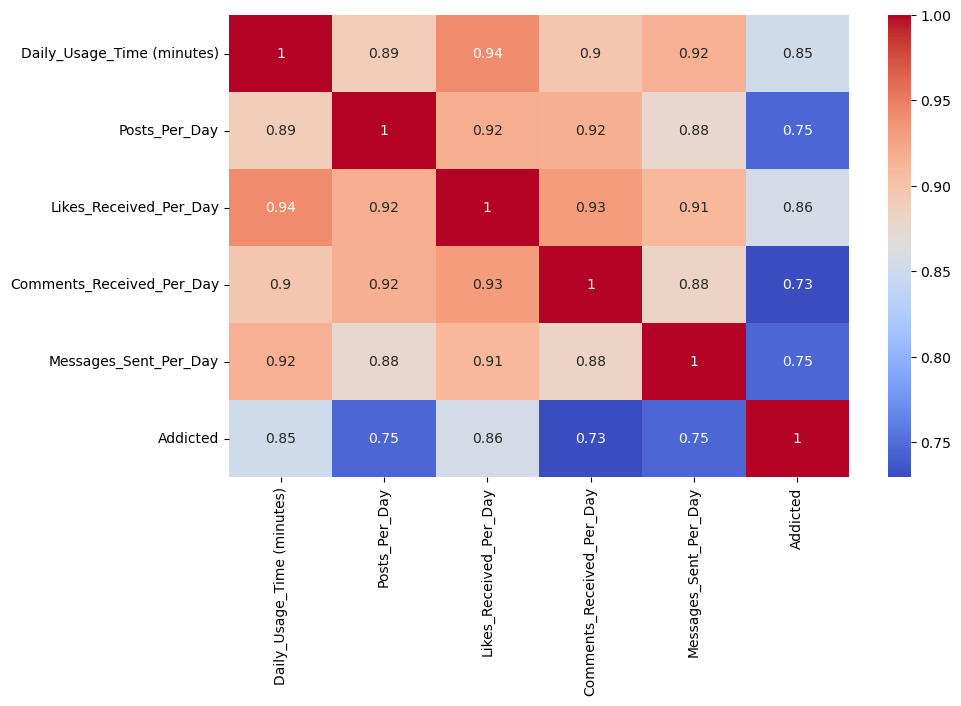

In [11]:
#heatmap of feature correlation
#for First Dataset
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

In [12]:
#Models for First Dataset

#Define variables for training and testing
#Features based only on user behavior
scaler = StandardScaler()

X = df[["Posts_Per_Day", "Likes_Received_Per_Day", "Comments_Received_Per_Day"]]
X_scaled = scaler.fit_transform(X)
y = df["Addicted"]
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.33, random_state = 42)

#Try a few different classification models to classify addicted/not addicted

#K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

#Random Forest
forest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
forest.fit(X_train, y_train)
y_pred_forest = forest.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_forest))
print(classification_report(y_test, y_pred_forest))

#Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

C:\Users\gresn\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Accuracy: 0.9939393939393939
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       257
           1       1.00      0.97      0.99        73

    accuracy                           0.99       330
   macro avg       1.00      0.99      0.99       330
weighted avg       0.99      0.99      0.99       330

Accuracy: 0.996969696969697
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       257
           1       1.00      0.99      0.99        73

    accuracy                           1.00       330
   macro avg       1.00      0.99      1.00       330
weighted avg       1.00      1.00      1.00       330

Logistic Regression Accuracy: 0.9878787878787879
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       257
           1       0.97      0.97      0.97        73

    accuracy                           0.99       330
   macro avg       0.9

In [3]:
import pandas as pd

df = pd.read_csv("C:/Users/gresn/OneDrive/CSDS312/ProjectFiles/sentimentdataset.csv")

df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["Date"] = df["Timestamp"].dt.date

#group by user and date
user_daily_activity = df.groupby(["User", "Date"]).agg(
    total_posts=("Text", "count"),  
    total_likes=("Likes", "sum"),
    total_retweets=("Retweets", "sum"),
    first_post=("Timestamp", "min"),  
    last_post=("Timestamp", "max"),   
).reset_index()

#time on app = timestamp of last post - timestamp of first post (each post takes 15 mins)
user_daily_activity["Active_Hours"] = (user_daily_activity["last_post"] - user_daily_activity["first_post"]).dt.total_seconds() / 3600
user_daily_activity["Active_Hours"].fillna(0, inplace=True)
user_daily_activity["Daily_Usage_Time"] = user_daily_activity["total_posts"] * 15 / 60  

#total interactions = likes + retweets
user_daily_activity["Total_Interactions"] = user_daily_activity["total_likes"] + user_daily_activity["total_retweets"]

#addiction = over 2 hours of usage OR over 100 interactions per day
user_daily_activity["Addicted"] = ((user_daily_activity["Daily_Usage_Time"] > 2) | (user_daily_activity["Total_Interactions"] > 100)).astype(int)

df = df.merge(user_daily_activity[["User", "Date", "Addicted"]], on=["User", "Date"], how="left")
df.dropna(inplace=True)
print(df[["User", "Date", "Addicted"]].head())

print("Number of addicted users:", df["Addicted"].sum())
total_users = df["User"].nunique()
print("Total number of users:", total_users)

             User        Date  Addicted
0   User123        2023-01-15         0
1   CommuterX      2023-01-15         0
2   FitnessFan     2023-01-15         0
3   AdventureX     2023-01-15         0
4   ChefCook       2023-01-15         0
Number of addicted users: 105
Total number of users: 685


In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


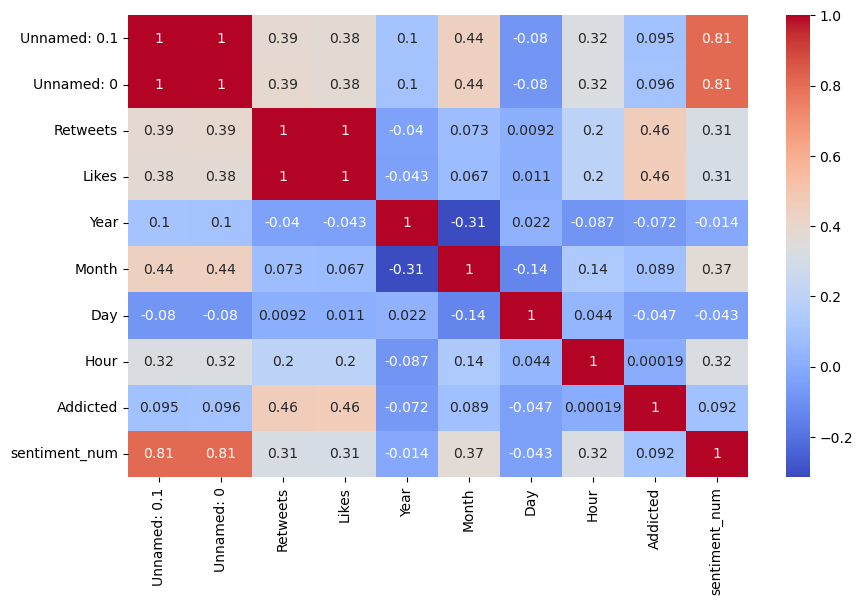

In [5]:
#heatmap of feature correlation
#for Sentiment Dataset
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

In [4]:
#Models for Sentiment Dataset

#Map sentiment to numerical values
df['sentiment_num'] = pd.factorize(df['Sentiment'])[0]

#Define variables for training and testing
scaler = StandardScaler()

#focusing on features having to do with behavior and sentiment 
X = df[["sentiment_num", 'Likes', 'Retweets']]
X_scaled = scaler.fit_transform(X)
y = df["Addicted"]
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.33, random_state = 42)

#Try a few different classification models to classify addicted/not addicted

#K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

#Random Forest
forest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
forest.fit(X_train, y_train)
y_pred_forest = forest.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_forest))
print(classification_report(y_test, y_pred_forest))

#Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

C:\Users\gresn\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Accuracy: 0.9504132231404959
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       208
           1       0.87      0.76      0.81        34

    accuracy                           0.95       242
   macro avg       0.91      0.87      0.89       242
weighted avg       0.95      0.95      0.95       242

Accuracy: 0.9462809917355371
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       208
           1       1.00      0.62      0.76        34

    accuracy                           0.95       242
   macro avg       0.97      0.81      0.87       242
weighted avg       0.95      0.95      0.94       242

Logistic Regression Accuracy: 0.9421487603305785
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       208
           1       1.00      0.59      0.74        34

    accuracy                           0.94       242
   macro avg       0.